In [7]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt

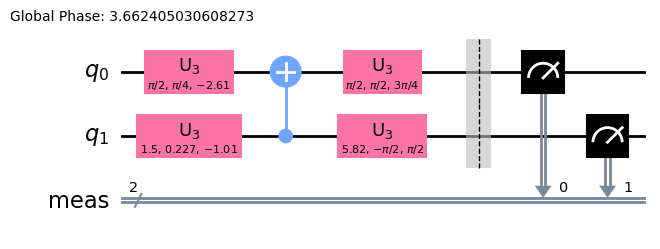

In [8]:
input_circuit = random_circuit(2, 4, seed=42, max_operands=2)
input_circuit = transpile(input_circuit, basis_gates=["u3", "cx"], optimization_level=3)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


In [9]:
from quantum_logical.basis import SNAILConcatWithAncilla

encoding = SNAILConcatWithAncilla()
A = encoding.logical_basis.transform_operator
A

Quantum object: dims = [[3, 3, 3], [2]], shape = (27, 2), type = oper, isherm = False
Qobj data =
[[ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]]

In [10]:
# Define the basis states for a qutrit
ket0 = qt.basis(3, 0)
ket1 = qt.basis(3, 1)
ket2 = qt.basis(3, 2)

# Identity operator for a qutrit
I = qt.qeye(3)

# Z operator for a qutrit
Z = qt.Qobj([[1, 0, 0], [0, 1, 0], [0, 0, -1]])

# Constructing the CZ gate
CZ = (
    qt.tensor(ket0 * ket0.dag(), I)
    + qt.tensor(ket1 * ket1.dag(), I)
    + qt.tensor(ket2 * ket2.dag(), Z)
)

# CZ is now a 9x9 matrix representing the CZ gate for qutrits
CZ

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]

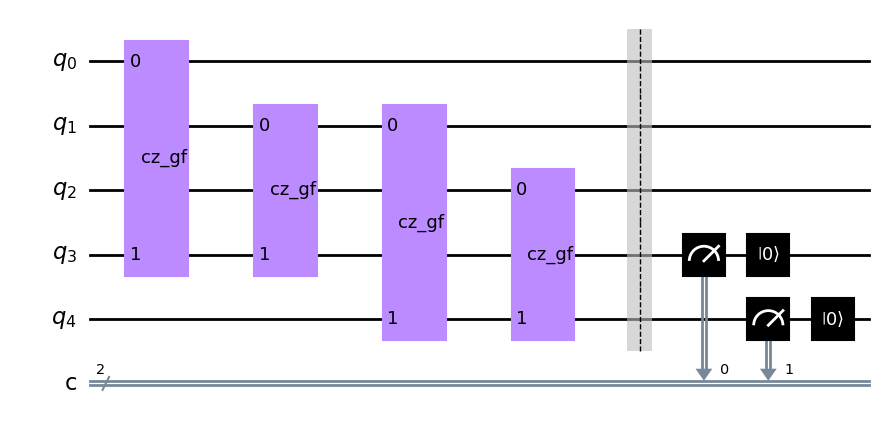

In [11]:
phase_syndrome_subcircuit = QuantumCircuit(5, 2)
cz_gf = QutritUnitary(CZ.full(), label="cz_gf")
phase_syndrome_subcircuit.append(cz_gf, [0, 3])
phase_syndrome_subcircuit.append(cz_gf, [1, 3])
phase_syndrome_subcircuit.append(cz_gf, [1, 4])
phase_syndrome_subcircuit.append(cz_gf, [2, 4])
phase_syndrome_subcircuit.barrier()
phase_syndrome_subcircuit.measure([3, 4], [0, 1])
phase_syndrome_subcircuit.reset([3, 4])

# classically conditioned on the syndrome, we can apply the appropriate correction


phase_syndrome_subcircuit.draw("mpl")

In [12]:
# # NOTE: in the expansion pass, we should probably be able to define known rules ahead of time
# # e.g. known translation between logical CNOT and encoded CNOT rather than relying on the
# # mathematical expression which will lead to a harder decomposition problem in the next stage
# from qiskit.transpiler.basepasses import TransformationPass

# class EncodedCircuitExpansionPass(TransformationPass):
#     def __init__(self, encoding):
#         super().__init__()
#         self.encoding = encoding

#     def run(self, dag):

In [13]:
# TODO: references
# https://qiskit.org/documentation/stable/0.28/tutorials/noise/6_repetition_code.html
# https://github.com/NCCR-SPIN/topological_codes/blob/master/topological_codes/circuits.py

In [14]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3)
stabilizer = QuantumRegister(2)
encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer
# Results of the encoding
results = ClassicalRegister(3)

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2)

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

## Initializing the Qubit

To protect a quantum state from errors, we must first prepare it.
In general we can prepare the state $$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$
In the circuit below we prepare the physical state $$|\Psi_1\rangle = |1\rangle$$

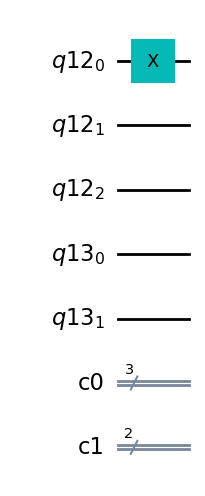

In [15]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])

initial_state.draw(output="mpl")

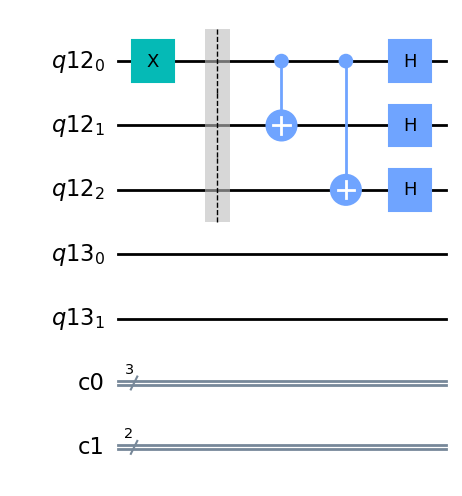

In [19]:
# Encoding using bit flip code
def encode_gf_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    qc.h(encoding)
    return qc


# The circuit encoding our qubit
encoding_circuit = encode_gf_phase_flip(initialize_circuit(), state, ancillas)

# The circuit including all parts so far
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")